In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_datasets as tfds
import keras

### Start with loading the dataset

In [38]:
batch_size = 10
img_height = 369
img_width = 496

#images original being a directory of the dataset, each subdirectory of images_original is a class folder
#each class folder contains samples belonging to that class
data_dir = './images_original'

#since spectrograms contain no meaningful RGB information grayscaling doesnt have any information loss
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = 'grayscale',
  label_mode = 'categorical')

val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = 'grayscale',
  label_mode = 'categorical')


Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.


### Defining the model architecture

In [39]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction=losses_utils.ReductionV2.AUTO,
    name='categorical_crossentropy'
),
  metrics=['accuracy'])

In [16]:
import os

EPOCHS = 10

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

fitted = model.fit(
  train,
  validation_data = val,
  epochs=EPOCHS,
  callbacks=[cp_callback]
)
model.summary()

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 2.5697 - accuracy: 0.1637
Epoch 1: saving model to training_1\cp.ckpt
80/80 [==============================] - 74s 925ms/step - loss: 2.5697 - accuracy: 0.1637 - val_loss: 2.0535 - val_accuracy: 0.2764
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 1.8209 - accuracy: 0.3638
Epoch 2: saving model to training_1\cp.ckpt
80/80 [==============================] - 76s 944ms/step - loss: 1.8209 - accuracy: 0.3638 - val_loss: 1.7164 - val_accuracy: 0.3518
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 1.3594 - accuracy: 0.5575
Epoch 3: saving model to training_1\cp.ckpt
80/80 [==============================] - 68s 853ms/step - loss: 1.3594 - accuracy: 0.5575 - val_loss: 1.5552 - val_accuracy: 0.4523
Epoch 4/10
80/80 [==============================] - ETA: 0s - loss: 0.8155 - accuracy: 0.7350
Epoch 4: saving model to training_1\cp.ckpt
80/80 [==============================] - 68s 849ms/s

In [19]:
#visualize architecture
keras.utils.plot_model(model, "cnn_from_scratch.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


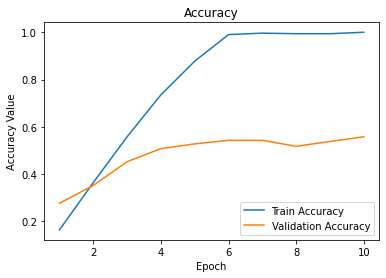

In [20]:
import matplotlib.pyplot as plt
import numpy as np

history = fitted 
#change the earlier line that says model.fit(blah blah blah) to fitted = model.fit(blah blah blah)

epoch_list = list(range(1,len(history.history['accuracy'])+1))
plt.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend(loc="lower right")

In [21]:
results = model.evaluate(val, batch_size=128)

20/20 [==============================] - 4s 176ms/step - loss: 1.8390 - accuracy: 0.5578


### Transfer Learning---using VGGish

In [48]:
from vggish import VGGish

import vggish_params as params

WEIGHTS_PATH = "vggish_audioset_weights_without_fc2.h5"
#you will have to download the pretrained model manually
#it was too big for the github
EPOCHS = 20

base_model = VGGish(include_top=False)

base_model.trainable = False

last_layer = base_model.output
x = tf.keras.layers.Flatten()(last_layer)
x = tf.keras.layers.Dense(units = 256, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 256, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 128, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 10, activation = 'softmax')(x)

pre_trained_model = tf.keras.Model(inputs = base_model.inputs, outputs = x)

pre_trained_model.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

In [ ]:
EPOCHS = 160

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

fitted_pre_trained = pre_trained_model.fit(train, 
                                           validation_data = val, 
                                           epochs = EPOCHS,
                                           callbacks=[cp_callback2])

Epoch 1/160
80/80 [==============================] - ETA: 0s - loss: 2.3505 - accuracy: 0.1187
Epoch 1: saving model to training_2\cp.ckpt
80/80 [==============================] - 144s 2s/step - loss: 2.3505 - accuracy: 0.1187 - val_loss: 2.3153 - val_accuracy: 0.1407
Epoch 2/160
80/80 [==============================] - ETA: 0s - loss: 2.2445 - accuracy: 0.1813
Epoch 2: saving model to training_2\cp.ckpt
80/80 [==============================] - 146s 2s/step - loss: 2.2445 - accuracy: 0.1813 - val_loss: 2.1885 - val_accuracy: 0.1809
Epoch 3/160
80/80 [==============================] - ETA: 0s - loss: 2.0515 - accuracy: 0.2962

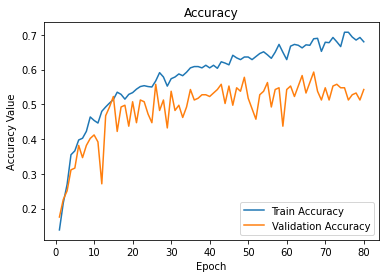

In [34]:
history = fitted_pre_trained 
#change the earlier line that says model.fit(blah blah blah) to fitted = model.fit(blah blah blah)

epoch_list = list(range(1,len(history.history['accuracy'])+1))
plt.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend(loc="lower right")

In [ ]:
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
keras.utils.plot_model(pre_trained_model, "pre_trained.png")

In [25]:
pre_trained_model.layers

In [9]:
for layer in pre_trained_model.layers:
    print("weights:", len(layer.weights))
    print("trainable_weights:", len(layer.trainable_weights))
    print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 2
non_trainable_weights: 0
